In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import sklearn as sk
from sklearn import metrics
import datetime as dt
import custom_metrics
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import Dataset, DataLoader

In [2]:
# Считывание погодных данных
weather_data = pd.read_csv('weather data chernov.csv')

weather_data = weather_data.rename(columns = {'time': 'Date'})
weather_data.Date = pd.to_datetime(weather_data.Date, format='ISO8601', errors='coerce')

In [3]:
generation_data = pd.read_excel("Данные ОИК ЧСЭС 01.05.2024 - 14.12.2024.xlsx")
new_column = generation_data.iloc[:,1] + generation_data.iloc[:,2]
generation_data = generation_data.drop(generation_data.columns[[1,2]], axis=1)
generation_data = generation_data.drop(0)
generation_data.insert(1, 'ПГБР Pген ГОУ Черновская', new_column)
columns_name = ['Date', 'Plan_X-1_Pgen', 'Fact_Pgen', 'Forecast_15_min', 'Forecast_30_min', 'Forecast_45_min', 'Forecast_60_min',
               'Forecast_2_hour', 'Forecast_3_hour', 'Forecast_4_hour', 'Insolation', "Temperature", 'Wind_speed']
generation_data.columns = columns_name
generation_data = generation_data.reset_index(drop=True)
generation_data.Date = pd.to_datetime(generation_data.Date)

Pgen = generation_data[['Date', 'Fact_Pgen']] # оставляю только дату для merge и генерацию

In [4]:
# using SO weather data
generation_data_weather = generation_data[['Fact_Pgen', 'Insolation', 'Temperature', 'Wind_speed']]
data = generation_data_weather.dropna()
data['Fact_Pgen'] = pd.to_numeric(data['Fact_Pgen'], errors='raise')
date_data = generation_data["Date"].dropna()

C:\Users\evb36\AppData\Local\Temp\ipykernel_528\3246902020.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Fact_Pgen'] = pd.to_numeric(data['Fact_Pgen'], errors='raise')


In [5]:
# Combine open-mete and SO data
generation_data_weather = generation_data[['Date', 'Fact_Pgen', 'Insolation', 'Temperature', 'Wind_speed']]
generation_data_weather['Fact_Pgen'] = pd.to_numeric(generation_data_weather['Fact_Pgen'], errors='raise')
date_data = generation_data_weather["Date"].dropna()
# merge to so data humidity and precipation from open-meteo
data = generation_data_weather.merge(weather_data[['Date', 'relative_humidity_2m (%)', 'precipitation (mm)']], on='Date', how='inner').drop_duplicates('Date').reset_index(drop=True)
data = data.dropna()
# exclude non-zero Pgen values
data = data.drop(data[8640:8640+96].index)
data = data.reset_index(drop=True)
data.Fact_Pgen[((data.Fact_Pgen <= 20) & (data.Insolation == 0) & (data.Fact_Pgen >= 0))] = 0.0
data_with_date = data
data_chernov = data.drop('Date', axis=1) # после слияние дата не нужна

C:\Users\evb36\AppData\Local\Temp\ipykernel_528\2156221334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generation_data_weather['Fact_Pgen'] = pd.to_numeric(generation_data_weather['Fact_Pgen'], errors='raise')
C:\Users\evb36\AppData\Local\Temp\ipykernel_528\2156221334.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a Data

In [20]:
# Prepare data for Khorinskaya
weather_data_khorinskaya = pd.read_csv('weather_data_Khorinskaya.csv')
weather_data_khorinskaya = weather_data_khorinskaya.rename(columns = {'time': 'Date'})
weather_data_khorinskaya.Date = pd.to_datetime(weather_data_khorinskaya.Date, format='ISO8601', errors='coerce')

# new_data = read
generation_data_khorinskaya = pd.read_excel('Данные ОИК Хоринская СЭС 01.03.2024 - 22.04.2025.xlsx', names=['Date', 'Wind_Speed', 'Temperature', 'Insolation', 'Fact_Pgen']).drop([0])
generation_data_khorinskaya = generation_data_khorinskaya.reindex(columns=['Date', 'Fact_Pgen', 'Insolation', 'Temperature', 'Wind_Speed'])#iloc[9:58]

weather_data_khorinskaya = weather_data_khorinskaya[['Date','relative_humidity_2m (%)', 'precipitation (mm)']]

data_khorinskaya_with_date = generation_data_khorinskaya.merge(weather_data_khorinskaya, how='inner')
# exclude non-zero Pgen values
data_khorinskaya_with_date = data_khorinskaya_with_date.drop(data_khorinskaya_with_date.iloc[9213:9213+96].index)
data_khorinskaya_with_date = data_khorinskaya_with_date.reset_index(drop=True)
data_khorinskaya_with_date.Fact_Pgen[((data_khorinskaya_with_date.Insolation == 0) & (data_khorinskaya_with_date.Fact_Pgen >= 0))] = 0.0
data_khorinskaya = data_khorinskaya_with_date.drop('Date', axis=1)

C:\Users\evb36\AppData\Local\Temp\ipykernel_528\1147113875.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_khorinskaya_with_date.Fact_Pgen[((data_khorinskaya_with_date.Insolation == 0) & (data_khorinskaya_with_date.Fact_Pgen >= 0))

In [22]:
class SolarDataset(Dataset):
    def __init__(self, data, look_back=4):
        """
        data: numpy array shape (num_timesteps, num_features)
              Структура: [погода_1, погода_2, ..., погода_K, генерация]
              (генерация — последний столбец)
        lookback: сколько предыдущих шагов использовать (N)
        """
        self.data = np.array(data, dtype=np.float16)
        self.look_back = look_back

    def __len__(self):
        return len(self.data) - self.look_back

    def __getitem__(self, idx):
        # Выбираем окно данных от (n - lookback) до (n)
        window = self.data[idx : idx + self.look_back + 1]

        # Разделяем погоду и генерацию
        weather_data = window[:, 1:]  # Все столбцы, кроме последнего
        generation = window[:, 0]  # Последний столбец (генерация)

        # Исторические данные (N шагов)
        historical_weather = weather_data[:-1]  # Погода с (n-N) до (n-1)
        historical_generation = generation[:-1]  # Генерация с (n-N) до (n-1)

        # Текущая погода (шаг n)
        current_weather = weather_data[-1]  # Погода на шаге n

        # Целевая генерация (шаг n)
        target = generation[-1]

        # Объединяем исторические данные в один тензор
        historical_data = np.concatenate([historical_weather, historical_generation.reshape(-1, 1)], axis=1)

        return (
            torch.FloatTensor(historical_data),  # (N, погода + генерация)
            torch.FloatTensor(current_weather),  # (погода на шаге n)
            torch.FloatTensor([target])         # генерация на шаге n
        )

# # 2. Позиционное кодирование
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)  # Четные индексы
        pe[:, 1::2] = torch.cos(position * div_term)  # Нечетные индексы
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        x = x + self.pe[:x.size(1)]  # Добавляем кодирование только для актуальной длины
        return x

class SolarTransformer(nn.Module):
    def __init__(self, num_weather_features, look_back=4, d_model=128, nhead=8, num_layers=3):
        super().__init__()
        self.lookback = look_back
        self.num_weather_features = num_weather_features

        # Проекция исторических данных
        self.hist_proj = nn.Linear(num_weather_features + 1, d_model)  # +1 для генерации

        # Позиционное кодирование для временных шагов
        self.pos_encoder = PositionalEncoding(d_model)

        # Трансформер-энкодер
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Проекция текущей погоды
        self.weather_proj = nn.Linear(num_weather_features, d_model)

        # Выходной слой
        self.output = nn.Sequential(
            nn.Linear(2 * d_model, d_model),  # Объединяем историю и текущую погоду
            nn.ReLU(),
            nn.Linear(d_model, 1))

    def forward(self, historical, current_weather):
        # historical: (batch_size, lookback, num_weather_features + 1)
        # current_weather: (batch_size, num_weather_features)

        # Проекция исторических данных
        hist_embedded = self.hist_proj(historical)  # (batch, lookback, d_model)
        hist_embedded = self.pos_encoder(hist_embedded)

        # Обработка трансформером
        hist_encoded = self.transformer(hist_embedded)  # (batch, lookback, d_model)

        # Усреднение по временной оси (можно заменить на [:, -1, :] для последнего шага)
        hist_encoded = hist_encoded.mean(dim=1)  # (batch, d_model)

        # Проекция текущей погоды
        current_embedded = self.weather_proj(current_weather)  # (batch, d_model)

        # Объединение признаков
        combined = torch.cat([hist_encoded, current_embedded], dim=1)  # (batch, 2*d_model)

        # Прогноз
        output = self.output(combined)  # (batch, 1)
        return output

def train_model(model, train_loader, val_loader, epochs=100, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
    
    best_val_loss = float('inf')
    
    # model.train(True)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Валидация
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                val_loss += criterion(outputs, batch_y).item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        scheduler.step(val_loss)
        
        # Сохраняем лучшую модель
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Загружаем лучшую модель
    model.load_state_dict(torch.load('best_model.pth'))
    return model

def get_fit_scaler (data):
    """
    Fit MinMaxScaler on the data. Data is pandas.DataFrame. Return scaler_X, scaler_y.
    """
    data = np.array(data)
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    scaler_X.fit(data[:, 1:])
    scaler_y.fit(data[:, 0].reshape(-1,1))
    return scaler_X, scaler_y

In [42]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

def train_with_cv(model, full_data, num_folds=5, look_back=5, batch_size=32, epochs=50, lr=1e-3):
    """
    Полный цикл обучения с кросс-валидацией
    
    Параметры:
    full_data - numpy array (num_samples, num_features), где ПЕРВЫЙ столбец - генерация
    num_folds - количество фолдов для кросс-валидации
    look_back - количество предыдущих шагов для анализа
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Нормализация данных (отдельно для погоды и генерации)
    scaler_gen = MinMaxScaler()
    scaler_weather = MinMaxScaler()
    
    # Первый столбец - генерация, остальные - погода
    generation = full_data[:, [0]]
    weather = full_data[:, 1:]
    
    # Нормализуем
    generation_norm = scaler_gen.fit_transform(generation)
    weather_norm = scaler_weather.fit_transform(weather)
    
    # Собираем обратно нормализованные данные
    norm_data = np.hstack([generation_norm, weather_norm])
    
    # Подготовка для K-Fold
    kf = KFold(n_splits=num_folds, shuffle=True)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(norm_data)):
        print(f"\n=== Fold {fold+1}/{num_folds} ===")
        
        # Создаем датасеты
        train_dataset = SolarDataset(norm_data[train_idx], look_back=look_back)
        val_dataset = SolarDataset(norm_data[val_idx], look_back=look_back)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
        criterion = nn.L1Loss()
        
        best_val_loss = float('inf')
        
        for epoch in range(epochs):
            # Обучение
            model.train()
            train_loss = 0
            for hist, weather, target in train_loader:
                hist, weather, target = hist.to(device), weather.to(device), target.to(device)
                
                optimizer.zero_grad()
                outputs = model(hist, weather)
                loss = criterion(outputs, target)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                
                train_loss += loss.item()
            
            # Валидация
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for hist, weather, target in val_loader:
                    hist, weather, target = hist.to(device), weather.to(device), target.to(device)
                    outputs = model(hist, weather)
                    val_loss += criterion(outputs, target).item()
            
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            scheduler.step(val_loss)
            
            # Сохраняем лучшую модель для этого фолда
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f'best_model_fold{fold}.pth')
            
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
        
        fold_results.append(best_val_loss)
    
    print("\n=== Результаты кросс-валидации ===")
    for fold, loss in enumerate(fold_results):
        print(f'Fold {fold+1} - Best Val Loss: {loss:.4f}')
    print(f'Mean Val Loss: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}')
    
    return fold_results, model

In [54]:
if __name__ == "__main__":
    # # Создаем синтетические данные для примера
    # # (1000 временных шагов, 1 генерация + 5 погодных признаков)
    # num_samples = 1000
    # num_features = 6  # 1 генерация + 5 погоды
    # data = np.random.randn(num_samples, num_features)
    look_back = 5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Инициализация модели
    num_weather_features = data_khorinskaya.shape[1] - 1
    model = SolarTransformer(
        num_weather_features=num_weather_features,
        look_back=look_back,
        d_model=128,
        nhead=8).to(device)
    # Запускаем кросс-валидацию
    cv_results, model = train_with_cv(
        model=model,
        full_data=np.array(data_khorinskaya),
        num_folds=2,
        look_back=look_back,
        batch_size=512,
        epochs=30,
        lr=1e-3
    )


=== Fold 1/2 ===
Epoch 1/30 | Train Loss: 0.1804 | Val Loss: 0.0797
Epoch 2/30 | Train Loss: 0.0855 | Val Loss: 0.0536
Epoch 3/30 | Train Loss: 0.0596 | Val Loss: 0.0417
Epoch 4/30 | Train Loss: 0.0563 | Val Loss: 0.0448
Epoch 5/30 | Train Loss: 0.0507 | Val Loss: 0.0600
Epoch 6/30 | Train Loss: 0.0475 | Val Loss: 0.0599
Epoch 7/30 | Train Loss: 0.0500 | Val Loss: 0.0367
Epoch 8/30 | Train Loss: 0.0515 | Val Loss: 0.0420
Epoch 9/30 | Train Loss: 0.0498 | Val Loss: 0.0421
Epoch 10/30 | Train Loss: 0.0470 | Val Loss: 0.0487
Epoch 11/30 | Train Loss: 0.0600 | Val Loss: 0.0453
Epoch 12/30 | Train Loss: 0.0384 | Val Loss: 0.0402
Epoch 13/30 | Train Loss: 0.0357 | Val Loss: 0.0379
Epoch 14/30 | Train Loss: 0.0342 | Val Loss: 0.0342
Epoch 15/30 | Train Loss: 0.0339 | Val Loss: 0.0343
Epoch 16/30 | Train Loss: 0.0338 | Val Loss: 0.0378
Epoch 17/30 | Train Loss: 0.0336 | Val Loss: 0.0366
Epoch 18/30 | Train Loss: 0.0338 | Val Loss: 0.0368
Epoch 19/30 | Train Loss: 0.0322 | Val Loss: 0.0341
Epo

In [64]:
def predict_generation(model, input_data, look_back=4, scaler_gen=None, scaler_weather=None, device='cuda'):
    """
    Предсказывает генерацию СЭС на основе входных данных
    
    Параметры:
    model - обученная модель SolarTransformer
    input_data - numpy array (num_samples, num_features) 
                где ПЕРВЫЙ столбец - генерация, остальные - погодные признаки
    lookback - количество предыдущих шагов, должно совпадать с обучением
    scaler_gen - скейлер для генерации (используется inverse_transform)
    scaler_weather - скейлер для погодных признаков
    device - устройство для вычислений ('cuda' или 'cpu')
    
    Возвращает:
    predictions - numpy array с предсказаниями генерации (денормализованными)
    """
    # Проверки входных данных
    assert input_data.shape[0] >= look_back + 1, \
        f"Нужно минимум {look_back + 1} временных шагов, получено {input_data.shape[0]}"
    
    generation = input_data[:, [0]]
    weather = input_data[:, 1:]
    # Нормализация данных (если переданы скейлеры)
    if scaler_gen is not None and scaler_weather is not None:
        
        generation_norm = scaler_gen.transform(generation)
        weather_norm = scaler_weather.transform(weather)
        
        norm_data = np.hstack([generation_norm, weather_norm])
    else:
        # Нормализация данных (отдельно для погоды и генерации)
        scaler_gen = MinMaxScaler()
        scaler_weather = MinMaxScaler()
        # Нормализуем
        generation_norm = scaler_gen.fit_transform(generation)
        weather_norm = scaler_weather.fit_transform(weather)
        norm_data = np.hstack([generation_norm, weather_norm])
    
    # Создаем датасет для прогнозирования
    dataset = SolarDataset(norm_data, look_back=look_back)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    
    # Прогнозирование
    model.eval()
    model.to(device)
    predictions = []
    
    with torch.no_grad():
        for hist, weather, _ in loader:
            hist = hist.to(device)
            weather = weather.to(device)
            
            outputs = model(hist, weather)
            predictions.append(outputs.cpu().numpy())
    
    predictions = np.concatenate(predictions, axis=0).flatten()
    
    # Денормализация предсказаний (если переданы скейлеры)
    predictions = scaler_gen.inverse_transform(predictions.reshape(-1, 1)).flatten()
    
    return predictions

In [68]:
# # Пример использования:
# if __name__ == "__main__":
#     # 1. Загружаем модель и скейлеры (пример)
#     num_weather_features = 5  # количество погодных признаков
#     model = SolarTransformer(
#         num_weather_features=num_weather_features,
#         lookback=4,
#         d_model=128,
#         nhead=8
#     )
#     model.load_state_dict(torch.load('best_model_fold0.pth'))
    
#     # 2. Загружаем скейлеры (должны быть сохранены после обучения)
#     scalers = torch.load('scalers.pth')  # Предположим, что сохранили как словарь
#     scaler_gen = scalers['generation']
#     scaler_weather = scalers['weather']
    
    # 3. Подготавливаем новые данные для прогноза
    # (должны содержать как минимум lookback+1 шагов)
new_data = np.array(data_chernov)  # 10 временных шагов, 1 генерация + 5 погоды
    
    # 4. Делаем прогноз
preds = predict_generation(
    model=model,
    input_data=new_data,
    look_back=5,
)

print("Предсказания генерации:", preds)

Предсказания генерации: [ 1.5700738   2.0242896   2.1112123  ... -0.02608211 -0.02696693
 -0.02753082]


In [72]:
data_chernov

,Fact_Pgen,Insolation,Temperature,Wind_speed,relative_humidity_2m (%),precipitation (mm)
0,0.154006,1,7.6,13.9,48.0,0.0
1,0.000800,6,7.2,5,50.0,0.0
2,0.210211,11,7,6.6,51.0,0.0
3,0.229413,11,6.8,3,52.0,0.0
4,0.397837,17,6.7,2.1,53.0,0.0
...,...,...,...,...,...,...
21787,0.000000,0,-11.4,5.1,71.0,0.0
21788,0.000000,0,-11.9,5,71.0,0.0
21789,0.000000,0,-11.6,4.1,71.0,0.0
21790,0.000000,0,-12.6,4.6,72.0,0.0


In [86]:
preds

array([ 1.5700738 ,  2.0242896 ,  2.1112123 , ..., -0.02608211,
       -0.02696693, -0.02753082], dtype=float32)

In [96]:
data_with_date

,Date,Fact_Pgen,Insolation,Temperature,Wind_speed,relative_humidity_2m (%),precipitation (mm)
0,2024-05-01 00:00:00,0.154006,1,7.6,13.9,48.0,0.0
1,2024-05-01 00:15:00,0.000800,6,7.2,5,50.0,0.0
2,2024-05-01 00:30:00,0.210211,11,7,6.6,51.0,0.0
3,2024-05-01 00:45:00,0.229413,11,6.8,3,52.0,0.0
4,2024-05-01 01:00:00,0.397837,17,6.7,2.1,53.0,0.0
...,...,...,...,...,...,...,...
21787,2024-12-14 22:45:00,0.000000,0,-11.4,5.1,71.0,0.0
21788,2024-12-14 23:00:00,0.000000,0,-11.9,5,71.0,0.0
21789,2024-12-14 23:15:00,0.000000,0,-11.6,4.1,71.0,0.0
21790,2024-12-14 23:30:00,0.000000,0,-12.6,4.6,72.0,0.0


In [106]:
type(y_pred_original)

pandas.core.series.Series

In [108]:
# sk.metrics.mean_absolute_error(data_chernov.iloc[5:, 0], preds)
y_pred_original = np.array(data_chernov.iloc[5:, 0])
y_val_original = preds
# data_chernov.iloc[5:, 0]

Средняя абсолютная ошибка (MAE) на интервале валидационных данных: 1.079260775136454
Корень из средней квадратичной ошибки (RMSE) на интервале валидационных данных: 4.145440209855592
Средняя абсолютная ошибка приведённая к максимальной генерацие (MAPE) на интервале валидационных данных: 4.78000020980835%
Средняя абсолютная ошибка приведённая к номинальной генерацие (MAPE_nominal) на интервале валидационных данных: 3.5975%


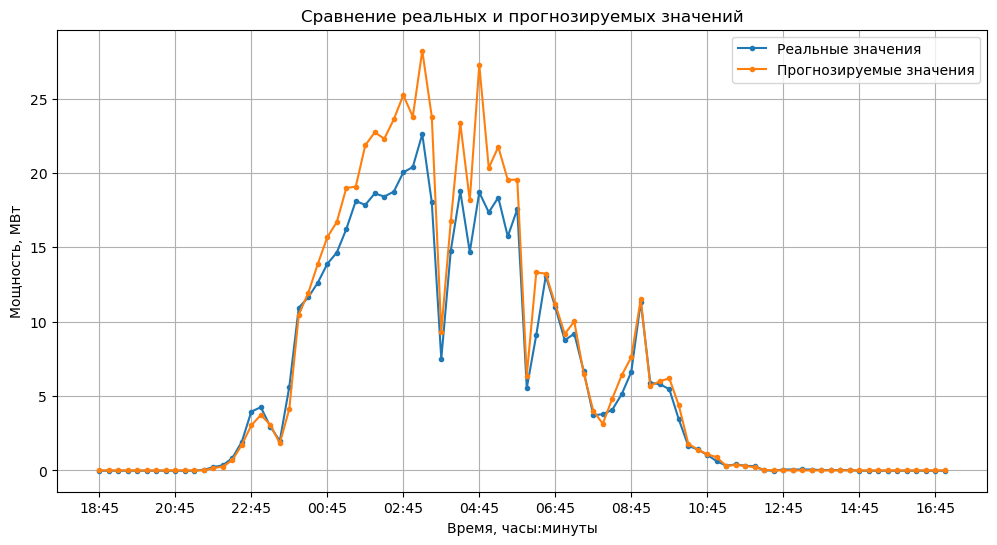

In [133]:
# Выбор интервала на валидационных данных
min_interval = 176 # #73 1518
max_interval = 266 # #121 1560
# Считаю ошибку на интервале
mae = metrics.mean_absolute_error(y_val_original[min_interval:max_interval], y_pred_original[min_interval:max_interval])
rmse = metrics.mean_squared_error(y_val_original[min_interval:max_interval], y_pred_original[min_interval:max_interval])
mape = custom_metrics.mape_to_max_power(y_val_original[min_interval:max_interval], y_pred_original[min_interval:max_interval])
print(f"""Средняя абсолютная ошибка (MAE) на интервале валидационных данных: {mae}
Корень из средней квадратичной ошибки (RMSE) на интервале валидационных данных: {rmse}
Средняя абсолютная ошибка приведённая к максимальной генерацие (MAPE) на интервале валидационных данных: {np.round(mape, 2)}%
Средняя абсолютная ошибка приведённая к номинальной генерацие (MAPE_nominal) на интервале валидационных данных: {np.round(mae/30*100,4)}%""")
x_time = data_with_date.iloc[min_interval-5:max_interval-5, 0].apply(lambda x: (x + dt.timedelta(hours=0)).strftime('%H:%M'))
# Визуалитзация интервала
plt.figure(figsize=(12,6))
plt.plot(x_time, y_val_original[min_interval:max_interval], label='Реальные значения', marker='.')
plt.plot(x_time, y_pred_original[min_interval:max_interval], label='Прогнозируемые значения', marker='.')
plt.xticks(range(0, (max_interval-min_interval), 8)) # регулирую колличество меток по оси х
plt.title('Сравнение реальных и прогнозируемых значений')
plt.xlabel('Время, часы:минуты')
plt.ylabel('Мощность, МВт')
plt.grid(True)
plt.legend()
plt.show()